In [61]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor

import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler


import hmmlearn


In [51]:
df_ooi = pd.read_csv("data/ooi-gi01sumo-sbd12-02-flortd000_655e_fffa_3b24.csv", skiprows=1, parse_dates=["UTC"])
df_ooi = df_ooi.rename(columns = {"UTC": "time", "m": "z", "microg.L-1": "mass_concentration_of_chlorophyll_a_in_sea_water", "m-1": "flubsct", })
del df_ooi["z"]
df_ooi = df_ooi.set_index("time")

In [52]:
df_ooi.head()

,mass_concentration_of_chlorophyll_a_in_sea_water,flubsct
time,,
2014-09-10 19:00:00+00:00,1.366800,0.003883
2014-09-10 19:01:00+00:00,1.430513,0.003996
2014-09-10 19:02:00+00:00,1.300551,0.003962
2014-09-10 19:03:00+00:00,1.715850,0.004220
2014-09-10 19:15:00+00:00,1.144603,0.004007


In [56]:
array_cross = df_ooi["flubsct"].resample("1h").mean().to_numpy()
array_obs = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1h").mean().to_numpy()
array_datetime = df_ooi["mass_concentration_of_chlorophyll_a_in_sea_water"].resample("1h").mean().index.to_numpy()

# flubsct: https://oceanobservatories.org/data-product/flubsct/

In [57]:
list_split_index = list(np.where(np.isnan(array_obs))[0])
list_split_index.append(len(array_obs))
list_split_index.insert(0, 0)
list_subseq = []
list_subseq_cross = []
list_subseq_datetime = []
for tmp_index in range(len(list_split_index) - 1):
    tmp_index_left = list_split_index[tmp_index] + 1
    tmp_index_right = list_split_index[tmp_index + 1]
    if tmp_index_right - tmp_index_left < 24 * 20:
        continue
    list_subseq.append(array_obs[tmp_index_left:tmp_index_right])
    list_subseq_datetime.append(array_datetime[tmp_index_left:tmp_index_right])
    list_subseq_cross.append(array_cross[tmp_index_left:tmp_index_right])
    

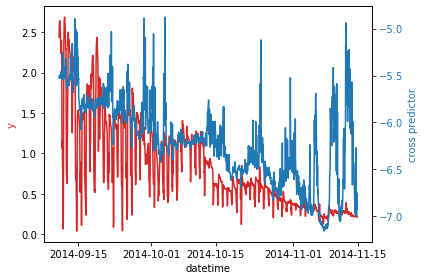

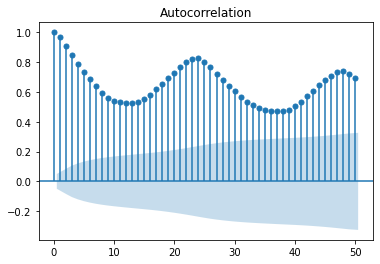

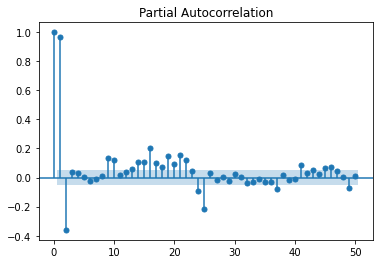

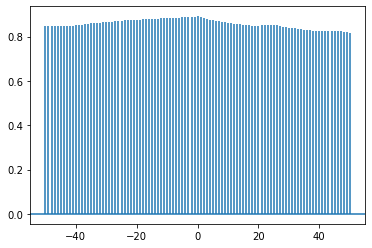

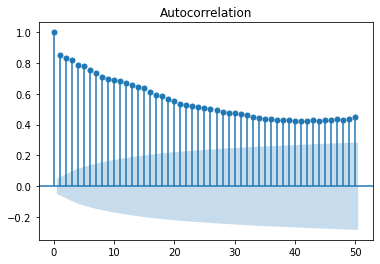

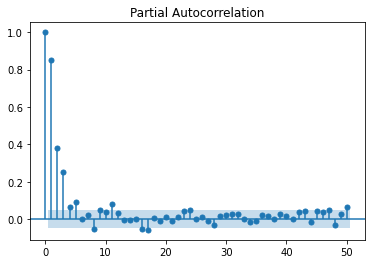

C:\Users\noah_\AppData\Local\Temp/ipykernel_32628/1557718089.py:10: RuntimeWarning: invalid value encountered in log
  ax2.plot(tmp_subseq_datetime, np.log(tmp_subseq_cross), color=color)


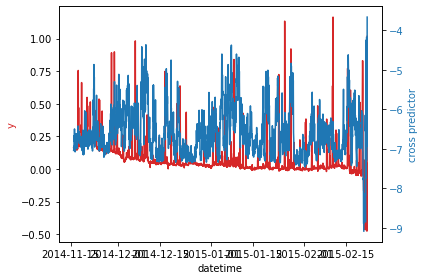

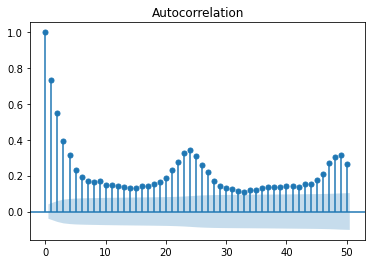

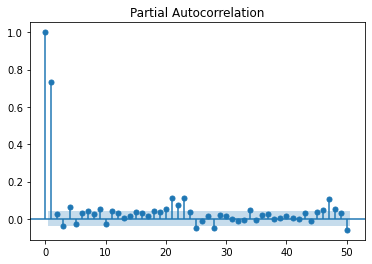

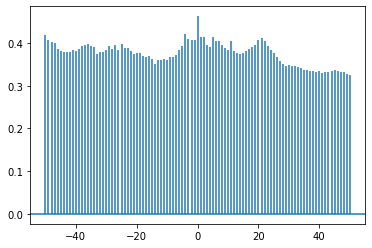

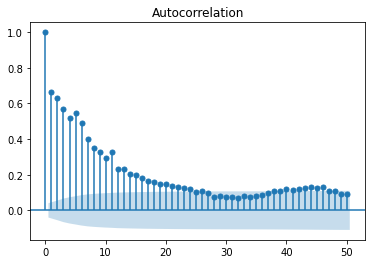

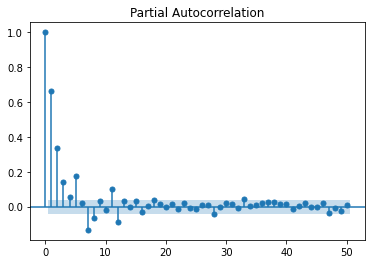

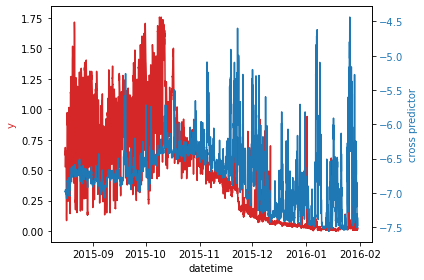

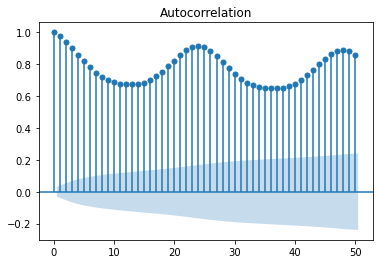

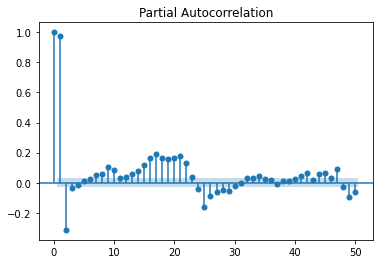

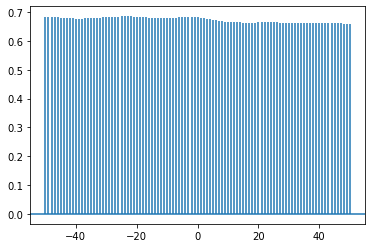

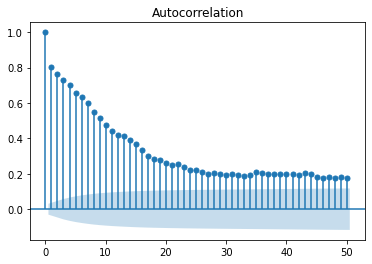

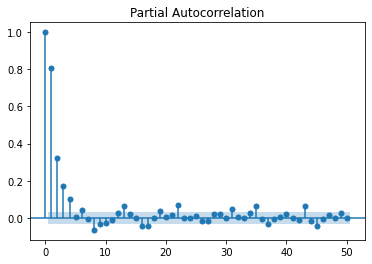

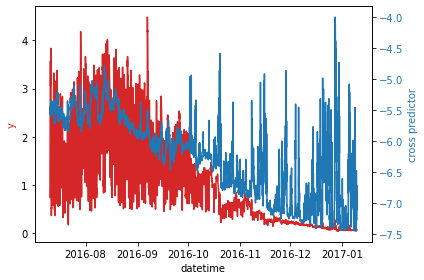

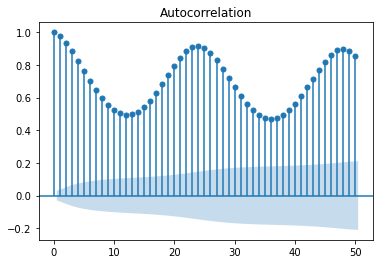

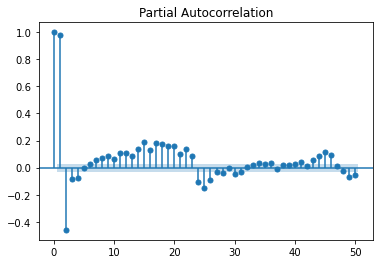

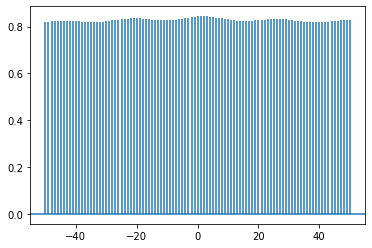

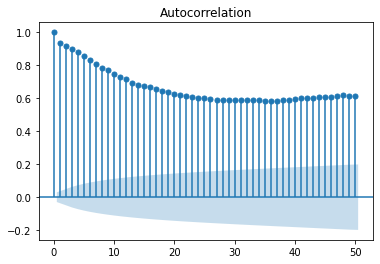

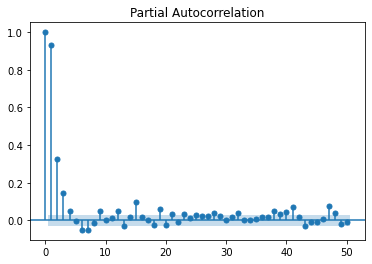

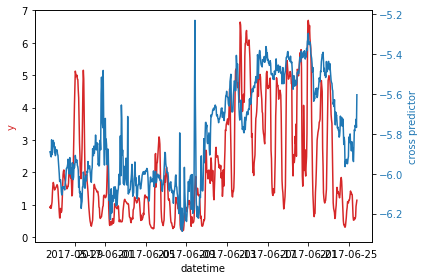

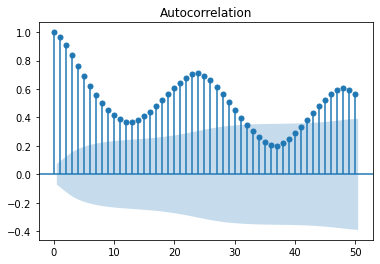

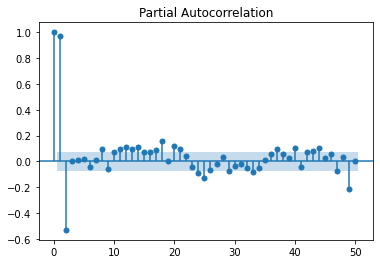

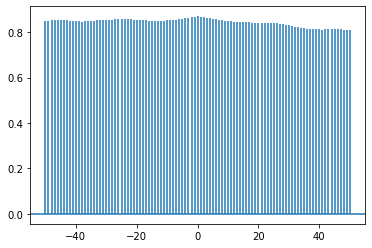

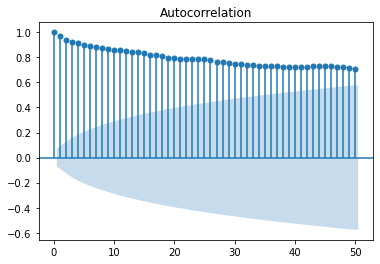

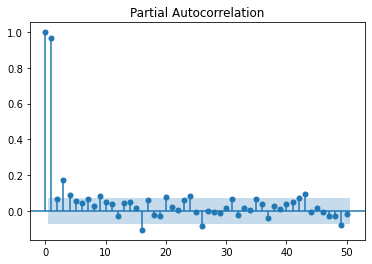

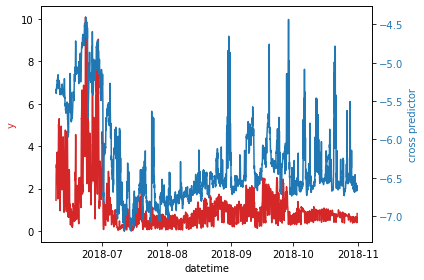

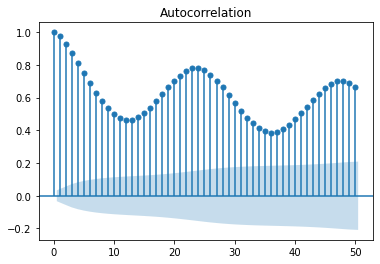

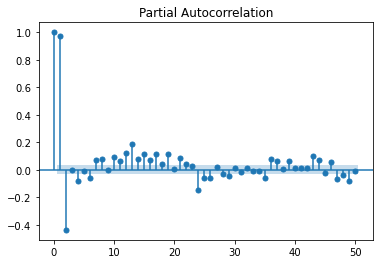

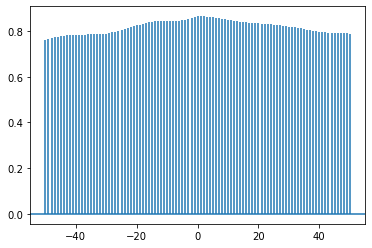

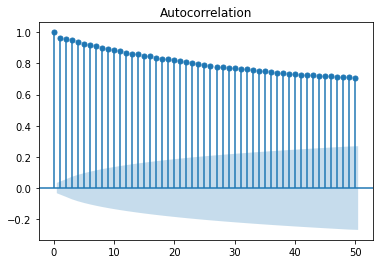

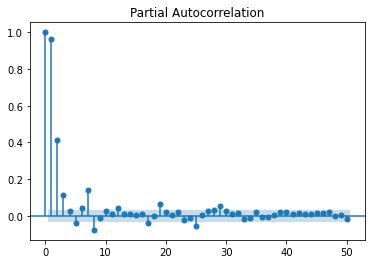

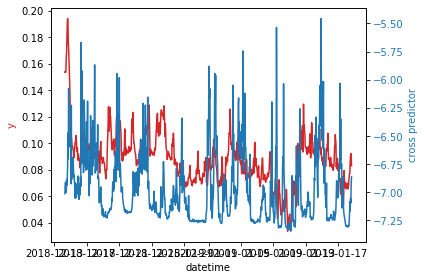

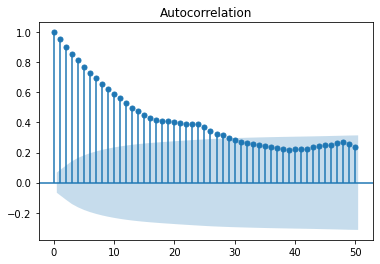

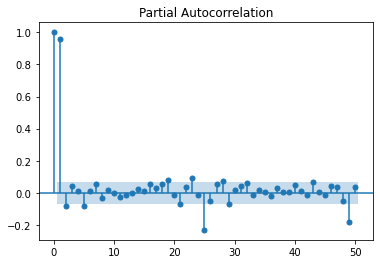

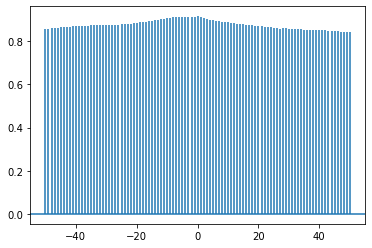

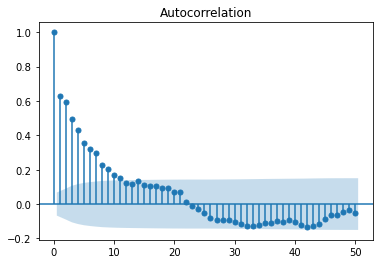

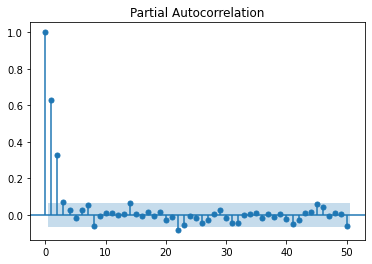

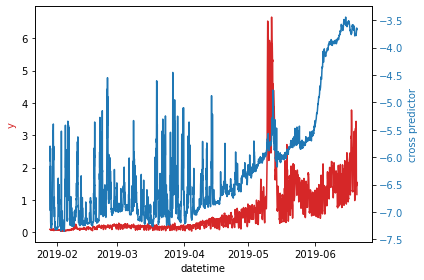

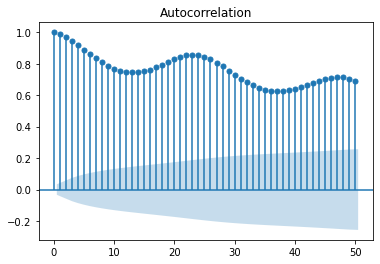

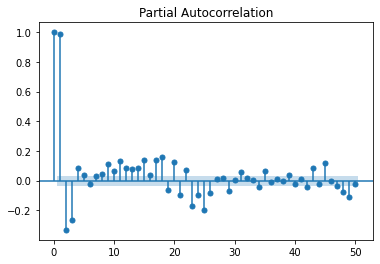

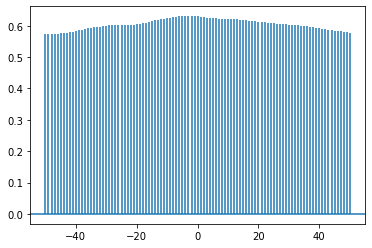

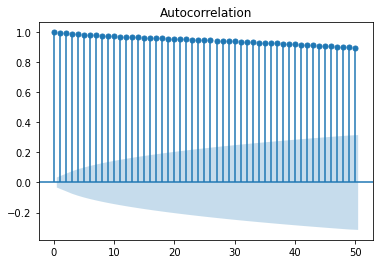

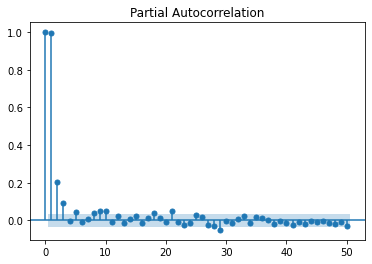

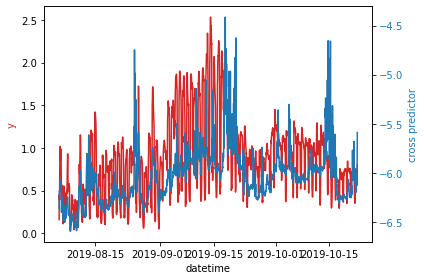

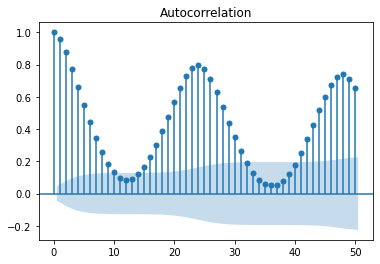

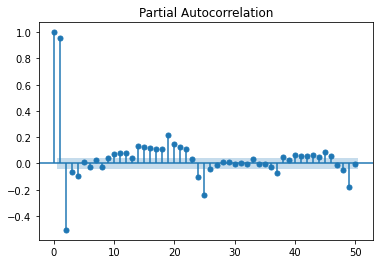

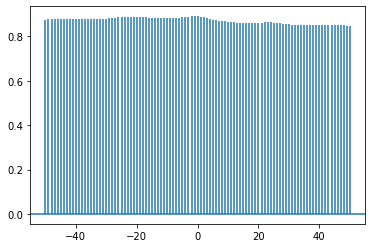

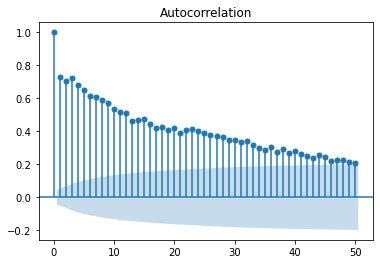

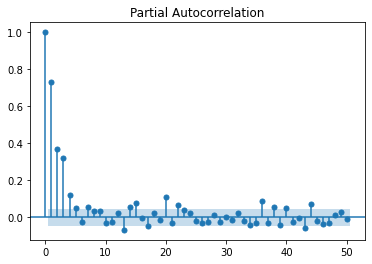

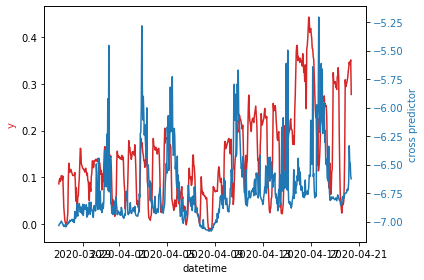

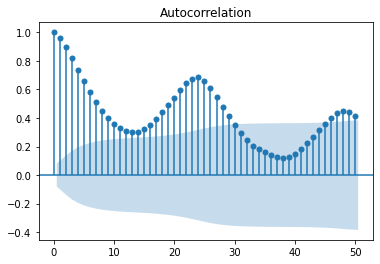

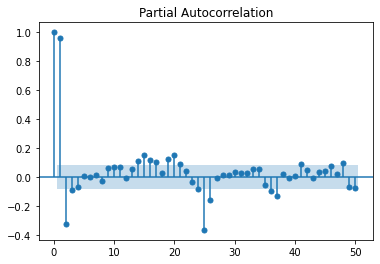

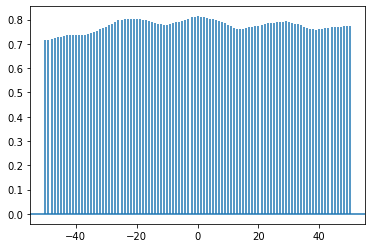

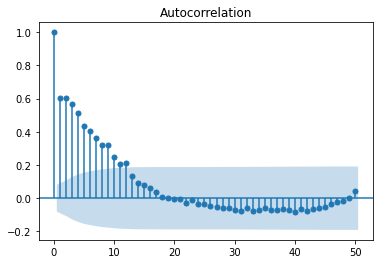

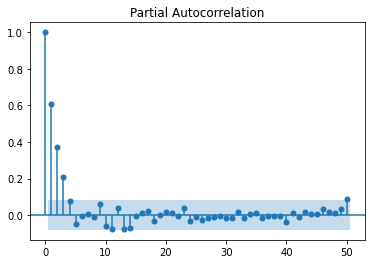

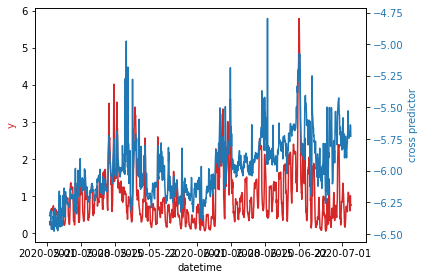

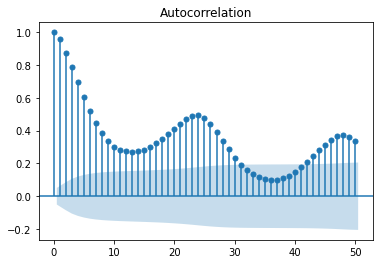

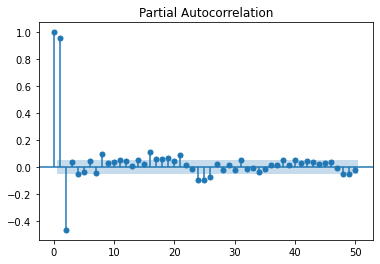

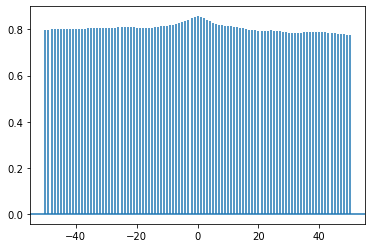

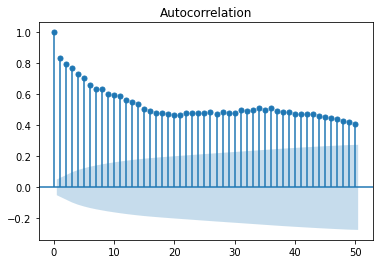

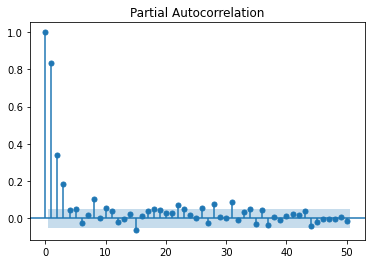

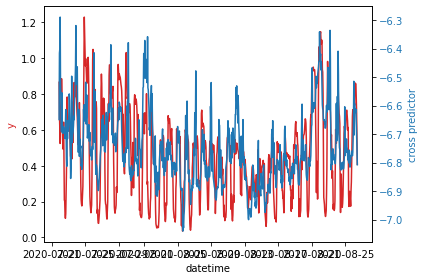

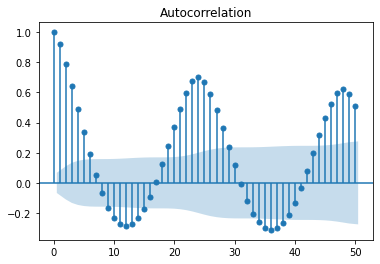

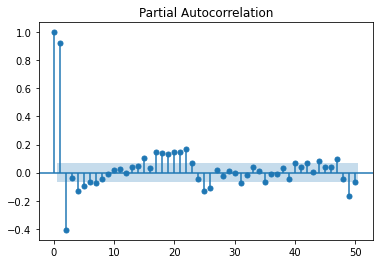

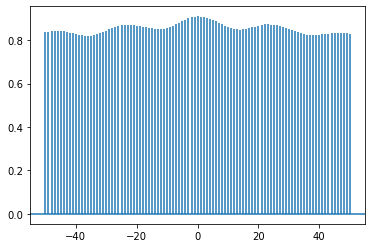

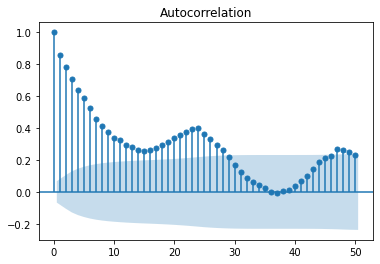

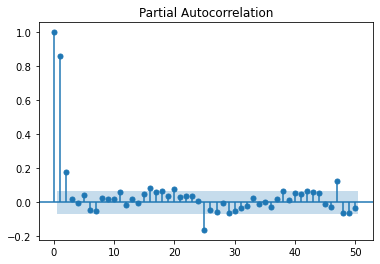

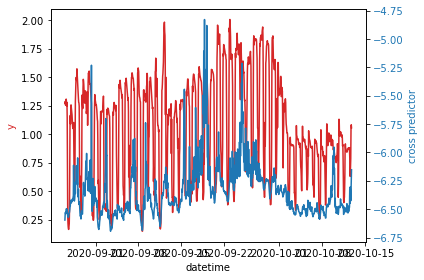

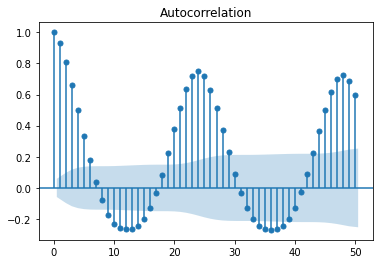

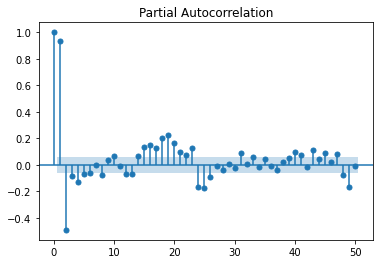

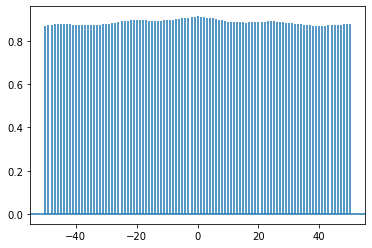

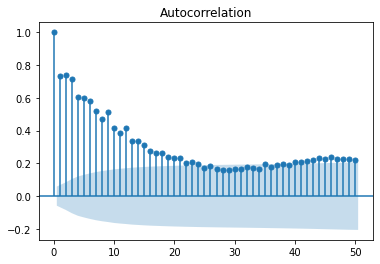

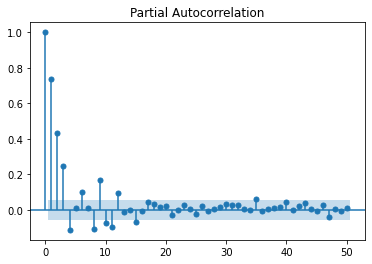

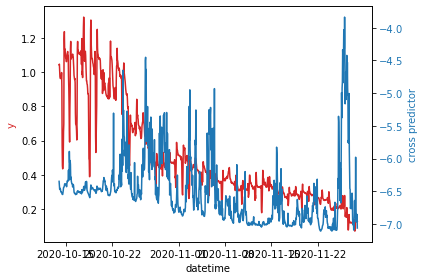

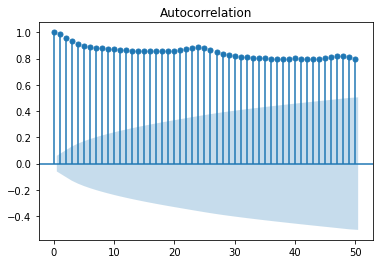

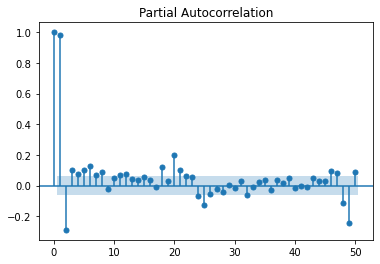

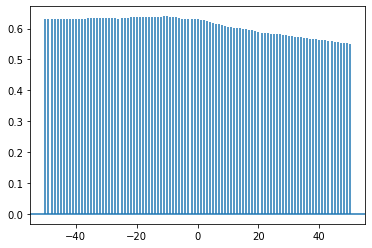

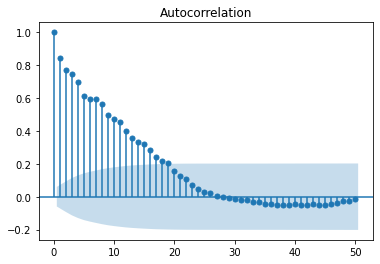

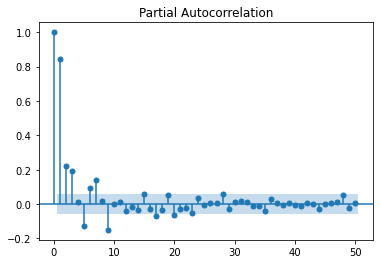

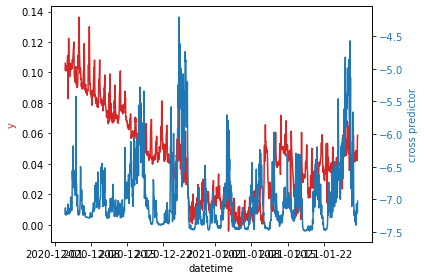

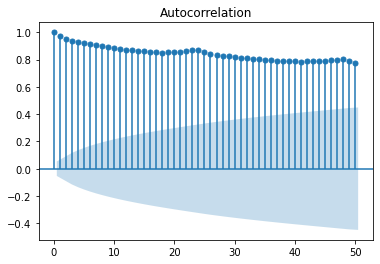

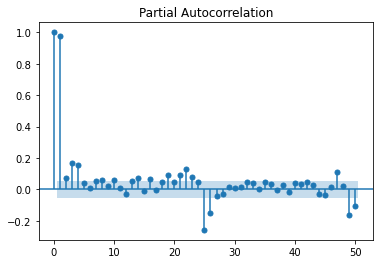

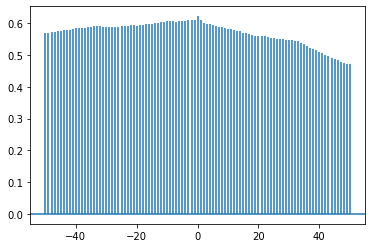

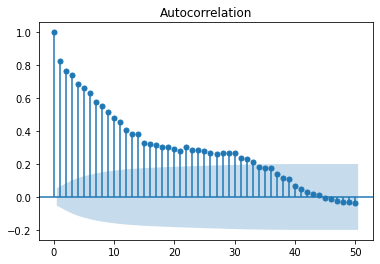

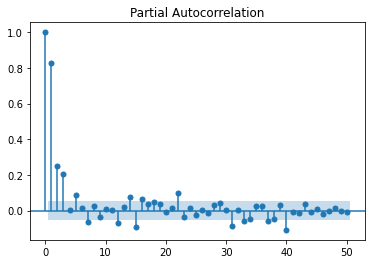

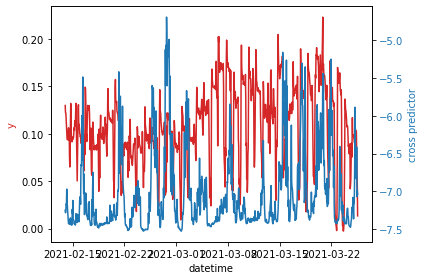

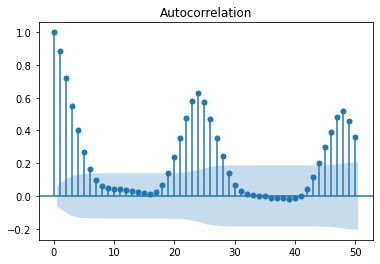

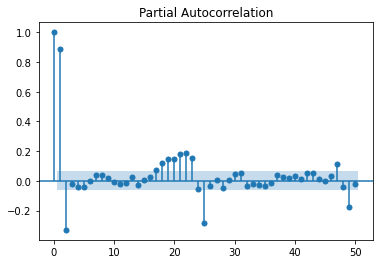

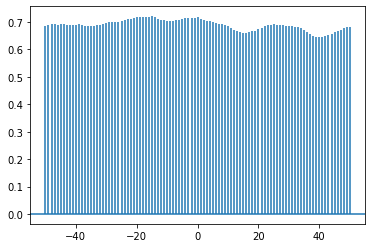

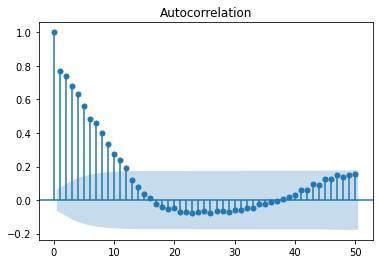

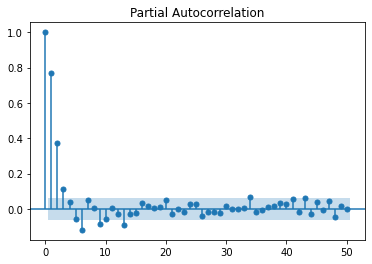

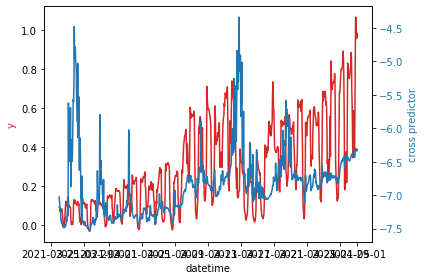

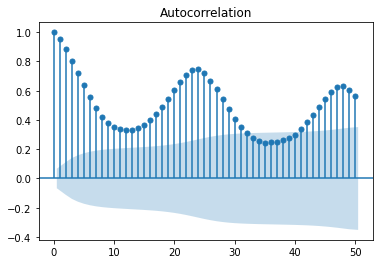

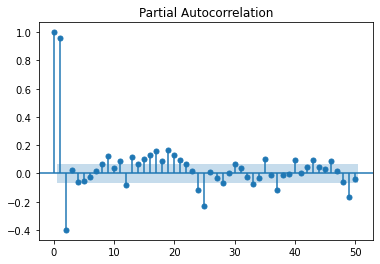

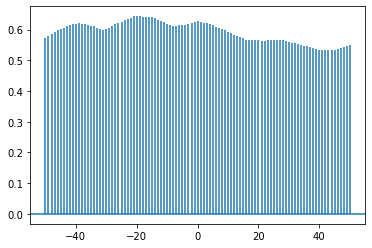

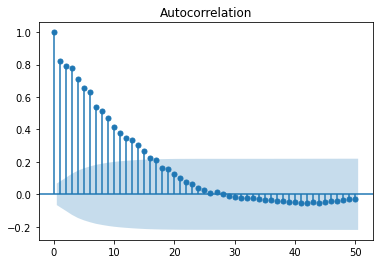

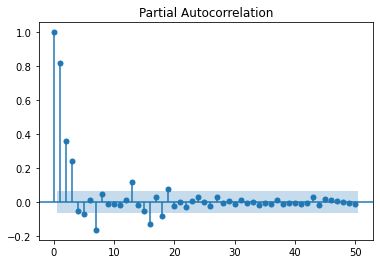

In [65]:
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('datetime')
    ax1.set_ylabel('y', color=color)
    ax1.plot(tmp_subseq_datetime, tmp_subseq, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('cross predictor', color=color) 
    ax2.plot(tmp_subseq_datetime, np.log(tmp_subseq_cross), color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()
    
    sm.graphics.tsa.plot_acf(tmp_subseq, lags = 50)
    plt.show()
    
    sm.graphics.tsa.plot_pacf(tmp_subseq, lags = 50)
    plt.show()
    
    plt.xcorr(tmp_subseq, tmp_subseq_cross, maxlags = 50)
    plt.show()
    
    sm.graphics.tsa.plot_acf(tmp_subseq_cross, lags = 50)
    plt.show()
    
    sm.graphics.tsa.plot_pacf(tmp_subseq_cross, lags = 50)
    plt.show()


## AR

In [71]:
X, y = [], []
y_naive = []
list_p_AR = [1, 2, 3, 24]
list_p_AR_cross = [1, 2, 3, 4, 5, 6]
max_p = max(max(list_p_AR), max(list_p_AR_cross))
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    for tmp_index_test in range(max(max_p, 24), len(tmp_subseq) - 24):
        
        tmp_X = []
        tmp_X.append(tmp_subseq_datetime[tmp_index_test].hour)
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        # for tmp_p in list_p_AR_cross:
        #     tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X.append(tmp_X)
        y.append(np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)]))
        y_naive.append(np.max(tmp_subseq[(tmp_index_test - 24):tmp_index_test]))


In [73]:
#X_train, X_test, y_train, y_test, y_naive_train, y_naive_test = train_test_split(X, y, y_naive, test_size=0.25)
n = len(X)
n_train = int(round(n * 0.75))
X_train, X_test, y_train, y_test, y_naive_train, y_naive_test = X[:n_train], X[n_train:], y[:n_train], y[n_train:], y_naive[:n_train], y_naive[n_train:]

In [68]:
print("r2 (naive) =", r2_score(y_pred = y_naive_test, y_true = y_test))

r2 (naive) = 0.6648704464794382


In [74]:
#reg = RidgeCV()
reg = RandomForestRegressor(n_estimators=500)
#reg = KNeighborsRegressor(n_neighbors = 10)

reg.fit(X_train, y_train)
print("r2 =", reg.score(X_test, y_test))


r2 = 0.689657568365692


In [70]:
reg = RidgeCV()
reg.fit(X_train, y_train)

reg.fit(X_train, y_train)
print("r2 =", reg.score(X_test, y_test))

r2 = 0.6822929898690884


### Cross-predictor's residual as features

In [77]:
X_cross, y_cross = [], []
list_datetime_cross = []
list_p_AR_cross = [1, 2, 3, 4, 5, 6]
max_p = max(list_p_AR_cross)
dict_datetime_cross_resid = dict()
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    for tmp_index_test in range(max(max_p, 24), len(tmp_subseq)):
        tmp_X = []
        tmp_X.append(tmp_subseq_datetime[tmp_index_test].hour)
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X_cross.append(tmp_X)
        y_cross.append(tmp_subseq[tmp_index_test])
        list_datetime_cross.append(tmp_subseq_datetime[tmp_index_test])


In [79]:
lr_cross = RidgeCV()
lr_cross.fit(X_cross, y_cross)
y_resid_cross = np.array(y_cross) - lr_cross.predict(X_cross)
dict_datetime_resid_cross = dict(zip(list_datetime_cross, y_resid_cross))

In [105]:
X, y = [], []
X_nocross = []
X_cross = []
y_naive = []
list_p_AR = [1, 2, 3, 24]
list_p_AR_cross = [1, 2, 3, 4, 5, 6]
max_p = max(max(list_p_AR), max(list_p_AR_cross))
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    for tmp_index_test in range(max(max_p, 24), len(tmp_subseq) - 24):
        
        tmp_X = []
        tmp_X.append(tmp_subseq_datetime[tmp_index_test].hour)
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        tmp_X_nocross = tmp_X[:]
        
        X_nocross.append(tmp_X_nocross)
        
        tmp_X = tmp_X_nocross[:]
        for tmp_p in list_p_AR_cross:
            tmp_X.append(dict_datetime_resid_cross.get(tmp_subseq_datetime[tmp_index_test - tmp_p], 0))
        X.append(tmp_X)
        
        tmp_X = tmp_X_nocross[:]
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X_cross.append(tmp_X)
        
        y.append(np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)]))
        y_naive.append(np.max(tmp_subseq[(tmp_index_test - 24):tmp_index_test]))
        

In [106]:
n = len(X)
n_train = int(round(n * 0.75))
X_train, X_test, y_train, y_test, y_naive_train, y_naive_test = X[:n_train], X[n_train:], y[:n_train], y[n_train:], y_naive[:n_train], y_naive[n_train:]
X_nocross_train, X_nocross_test = X_nocross[:n_train], X_nocross[n_train:]
X_cross_train, X_cross_test = X_cross[:n_train], X_cross[n_train:]

In [107]:
print("Naive, r2 =", r2_score(y_pred = y_naive_test, y_true = y_test))
    
reg = RidgeCV()
reg.fit(X_train, y_train)
print("Ridge, cross resid, r2 =", reg.score(X_test, y_test))

reg = RidgeCV()
reg.fit(X_cross_train, y_train)
print("Ridge, cross origin, r2 =", reg.score(X_cross_test, y_test))

reg = RidgeCV()
reg.fit(X_nocross_train, y_train)
print("Ridge, no cross, r2 =", reg.score(X_nocross_test, y_test))

reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_train, y_train)
print("RF, cross resid, r2 =", reg.score(X_test, y_test))

reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_cross_train, y_train)
print("RF, cross origin, r2 =", reg.score(X_cross_test, y_test))

reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_nocross_train, y_train)
print("RF, no cross, r2 =", reg.score(X_nocross_test, y_test))


Naive, r2 = 0.6648704464794382
Ridge, cross resid, r2 = 0.7032873593763933
Ridge, cross origin, r2 = 0.6822929898690884
Ridge, no cross, r2 = 0.6746652946403324
RF, cross resid, r2 = 0.7242330425797936
RF, cross origin, r2 = 0.7304376657426357
RF, no cross, r2 = 0.6884173211998936


### Subseq by subseq

In [114]:

y_test_all = []
y_pred_naive_all = []
y_pred_ridge_crossresid_all, y_pred_ridge_cross_all, y_pred_ridge_nocross_all = [], [], []
y_pred_rf_crossresid_all, y_pred_rf_cross_all, y_pred_rf_nocross_all = [], [], []

y_train_concat, y_test_concat, y_naive_train_concat, y_naive_test_concat = [], [], [], []
X_crossresid_train_concat, X_crossresid_test_concat = [], []
X_nocross_train_concat, X_nocross_test_concat = [], []
X_cross_train_concat, X_cross_test_concat = [], []

list_p_AR = [1, 2, 3, 24]
list_p_AR_cross = [1, 2, 3, 4, 5, 6]
max_p = max(max(list_p_AR), max(list_p_AR_cross))
for tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime in zip(list_subseq, list_subseq_cross, list_subseq_datetime):
    
    y, y_naive = [], []
    X_crossresid = []
    X_nocross, X_cross = [], []
    
    for tmp_index_test in range(max(max_p, 24), len(tmp_subseq) - 24):
        
        tmp_X = []
        tmp_X.append(tmp_subseq_datetime[tmp_index_test].hour)
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        tmp_X_nocross = tmp_X[:]

        X_nocross.append(tmp_X_nocross)
        
        tmp_X = tmp_X_nocross[:]
        for tmp_p in list_p_AR_cross:
            tmp_X.append(dict_datetime_resid_cross.get(tmp_subseq_datetime[tmp_index_test - tmp_p], 0))
        X_crossresid.append(tmp_X)
        
        tmp_X = tmp_X_nocross[:]
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X_cross.append(tmp_X)
        
        y.append(np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)]))
        y_naive.append(np.max(tmp_subseq[(tmp_index_test - 24):tmp_index_test]))
        
    n = len(y)
    n_train = int(round(n * 0.75))
    y_train, y_test, y_naive_train, y_naive_test = y[:n_train], y[n_train:], y_naive[:n_train], y_naive[n_train:]
    X_crossresid_train, X_crossresid_test = X_crossresid[:n_train], X_crossresid[n_train:]
    X_nocross_train, X_nocross_test = X_nocross[:n_train], X_nocross[n_train:]
    X_cross_train, X_cross_test = X_cross[:n_train], X_cross[n_train:]
    
    y_train_concat.extend(y_train)
    y_test_concat.extend(y_test)
    y_naive_train_concat.extend(y_naive_train)
    y_naive_test_concat.extend(y_naive_test)
    X_crossresid_train_concat.extend(X_crossresid_train)
    X_crossresid_test_concat.extend(X_crossresid_test)
    X_nocross_train_concat.extend(X_nocross_train)
    X_nocross_test_concat.extend(X_nocross_test)
    X_cross_train_concat.extend(X_cross_train)
    X_cross_test_concat.extend(X_cross_test)
    
    print(n, tmp_subseq_datetime.min(), tmp_subseq_datetime.max())
    
    y_test_all.extend(y_test)
    
    print("Naive, r2 =", r2_score(y_pred = y_naive_test, y_true = y_test))
    y_pred_naive_all.extend(y_naive_test)
    
    reg = RidgeCV()
    reg.fit(X_crossresid_train, y_train)
    print("Ridge, cross resid, r2 =", reg.score(X_crossresid_test, y_test))
    y_pred_ridge_crossresid_all.extend(reg.predict(X_crossresid_test))

    reg = RidgeCV()
    reg.fit(X_cross_train, y_train)
    print("Ridge, cross origin, r2 =", reg.score(X_cross_test, y_test))
    y_pred_ridge_cross_all.extend(reg.predict(X_cross_test))
    
    reg = RidgeCV()
    reg.fit(X_nocross_train, y_train)
    print("Ridge, no cross, r2 =", reg.score(X_nocross_test, y_test))
    y_pred_ridge_nocross_all.extend(reg.predict(X_nocross_test))

    reg = RandomForestRegressor(n_estimators=500)
    reg.fit(X_crossresid_train, y_train)
    print("RF, cross resid, r2 =", reg.score(X_crossresid_test, y_test))
    y_pred_rf_crossresid_all.extend(reg.predict(X_crossresid_test))

    reg = RandomForestRegressor(n_estimators=500)
    reg.fit(X_cross_train, y_train)
    print("RF, cross origin, r2 =", reg.score(X_cross_test, y_test))
    y_pred_rf_cross_all.extend(reg.predict(X_cross_test))
    
    reg = RandomForestRegressor(n_estimators=500)
    reg.fit(X_nocross_train, y_train)
    print("RF, no cross, r2 =", reg.score(X_nocross_test, y_test))
    y_pred_rf_nocross_all.extend(reg.predict(X_nocross_test))
    
    print() 

print("all")
print("Naive, r2 =", r2_score(y_pred = y_pred_naive_all, y_true = y_test_all))
print("Ridge, cross resid, r2 =", r2_score(y_pred = y_pred_ridge_crossresid_all, y_true = y_test_all))
print("Ridge, cross origin, r2 =", r2_score(y_pred = y_pred_ridge_cross_all, y_true = y_test_all))
print("Ridge, no cross, r2 =", r2_score(y_pred = y_pred_ridge_nocross_all, y_true = y_test_all))
print("RF, cross resid, r2 =", r2_score(y_pred = y_pred_rf_crossresid_all, y_true = y_test_all))
print("RF, cross origin, r2 =", r2_score(y_pred = y_pred_rf_cross_all, y_true = y_test_all))
print("RF, no cross, r2 =", r2_score(y_pred = y_pred_rf_nocross_all, y_true = y_test_all))
print()

print("all (refit)")

reg = RidgeCV()
reg.fit(X_crossresid_train_concat, y_train_concat)
print("Ridge, cross resid, r2 =", reg.score(X_crossresid_test_concat, y_test_concat))

reg = RidgeCV()
reg.fit(X_cross_train_concat, y_train_concat)
print("Ridge, cross origin, r2 =", reg.score(X_cross_test_concat, y_test_concat))

reg = RidgeCV()
reg.fit(X_nocross_train_concat, y_train_concat)
print("Ridge, no cross, r2 =", reg.score(X_nocross_test_concat, y_test_concat))

reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_crossresid_train_concat, y_train_concat)
print("RF, cross resid, r2 =", reg.score(X_crossresid_test_concat, y_test_concat))

reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_cross_train_concat, y_train_concat)
print("RF, cross origin, r2 =", reg.score(X_cross_test_concat, y_test_concat))

reg = RandomForestRegressor(n_estimators=500)
reg.fit(X_nocross_train_concat, y_train_concat)
print("RF, no cross, r2 =", reg.score(X_nocross_test_concat, y_test_concat))

print() 
        

1516 2014-09-10 20:00:00+00:00 2014-11-14 23:00:00+00:00
Naive, r2 = -0.3352641547608519
Ridge, cross resid, r2 = -12.473623230069435
Ridge, cross origin, r2 = -12.091112305793562
Ridge, no cross, r2 = -12.018960517613593
RF, cross resid, r2 = -89.22800059564345
RF, cross origin, r2 = -50.39119672668579
RF, no cross, r2 = -15.866352275937771

2309 2014-11-16 00:00:00+00:00 2015-02-22 04:00:00+00:00
Naive, r2 = -0.9480061999161151
Ridge, cross resid, r2 = 0.05631667984835087
Ridge, cross origin, r2 = 0.05213157198313911
Ridge, no cross, r2 = 0.05115545009645761
RF, cross resid, r2 = -0.6245387848409414
RF, cross origin, r2 = -0.4880939138202167
RF, no cross, r2 = -0.563863942088588

3982 2015-08-15 19:00:00+00:00 2016-01-30 16:00:00+00:00
Naive, r2 = -0.5373869292817028
Ridge, cross resid, r2 = -1.0356882621358658
Ridge, cross origin, r2 = -0.7757902714919591
Ridge, no cross, r2 = -0.761505847978615
RF, cross resid, r2 = -0.007872689258475285
RF, cross origin, r2 = -0.05173515880214885


### Rolling prediction

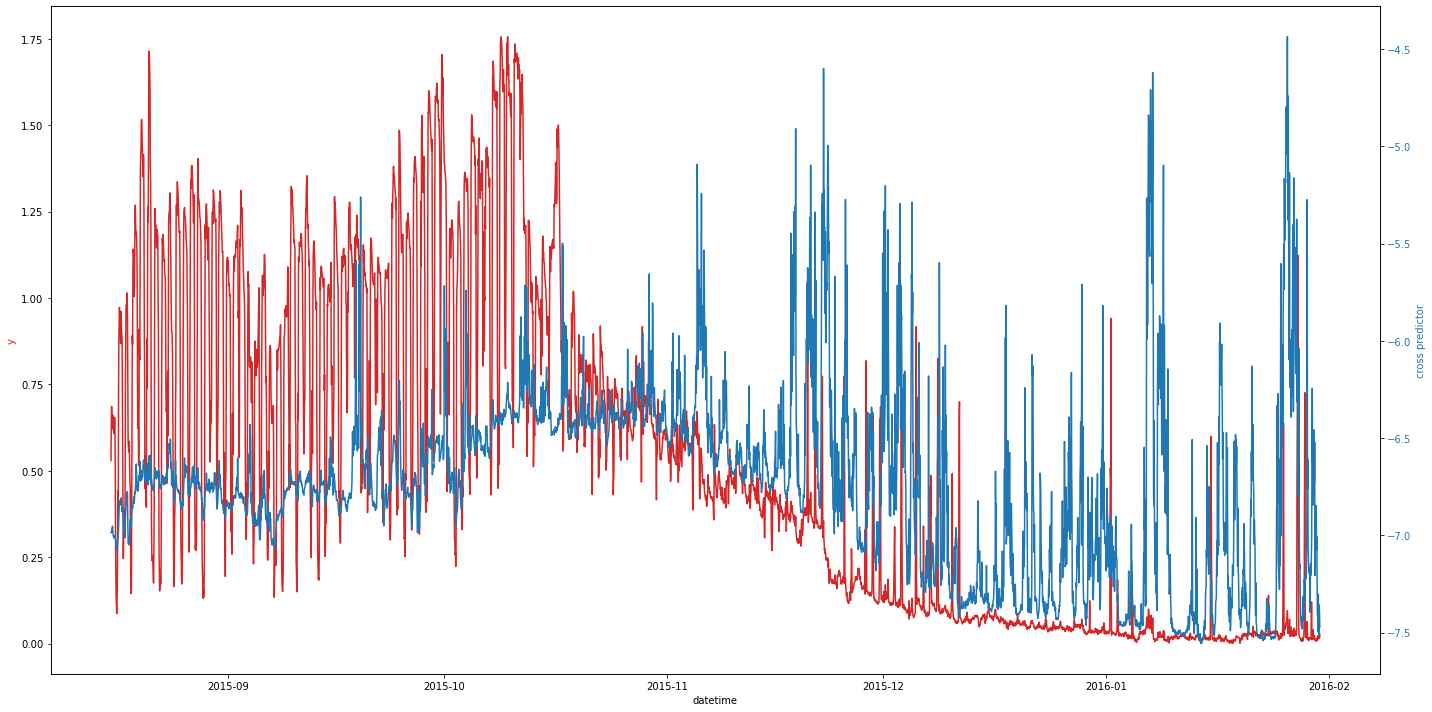

In [156]:

list_p_AR = [1, 2, 3, 24]
list_p_AR_cross = [1, 2, 3, 4, 5, 6]
max_p = max(max(list_p_AR), max(list_p_AR_cross))

X_crossresid = []
X_nocross = []
X_cross = []
y = []
y_naive = []
list_datetime = []
for cc_subseq, (tmp_subseq, tmp_subseq_cross, tmp_subseq_datetime) in enumerate(zip(list_subseq, list_subseq_cross, list_subseq_datetime)):
    if cc_subseq != 2:
        continue
        
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('datetime')
    ax1.set_ylabel('y', color=color)
    ax1.plot(tmp_subseq_datetime, tmp_subseq, color=color)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('cross predictor', color=color) 
    ax2.plot(tmp_subseq_datetime, np.log(tmp_subseq_cross), color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()
    plt.show()
        
    for tmp_index_test in range(max(max_p, 24), len(tmp_subseq) - 24):
        
        tmp_X = []
        tmp_X.append(tmp_subseq_datetime[tmp_index_test].hour)
        for tmp_p in list_p_AR:
            tmp_X.append(tmp_subseq[tmp_index_test - tmp_p])
        tmp_X_nocross = tmp_X[:]
        
        X_nocross.append(tmp_X_nocross)
        
        tmp_X = tmp_X_nocross[:]
        for tmp_p in list_p_AR_cross:
            tmp_X.append(dict_datetime_resid_cross.get(tmp_subseq_datetime[tmp_index_test - tmp_p], 0))
        X_crossresid.append(tmp_X)
        
        tmp_X = tmp_X_nocross[:]
        for tmp_p in list_p_AR_cross:
            tmp_X.append(tmp_subseq_cross[tmp_index_test - tmp_p])
        X_cross.append(tmp_X)
        
        y.append(np.max(tmp_subseq[tmp_index_test:(tmp_index_test + 24)]))
        y_naive.append(np.max(tmp_subseq[(tmp_index_test - 24):tmp_index_test]))
        list_datetime.append(tmp_subseq_datetime[tmp_index_test])
        

In [157]:

rolling_train_len = 7 * 24

y_test = []
y_naive_test = []
y_pred_nocross, y_pred_crossresid, y_pred_cross = [], [], []
list_coef_nocross, list_coef_crossresid, list_coef_cross = [], [], []
list_datetime_test = []
for indext_test in range(rolling_train_len, len(y)):
    
    if (list_datetime[indext_test] - list_datetime[indext_test - rolling_train_len]) > pd.Timedelta('10 days'):
        continue
    
    list_datetime_test.append(list_datetime[indext_test])
    
    y_test.append(y[indext_test])
    y_naive_test.append(y_naive[indext_test])
    
    reg = RidgeCV()
    reg.fit(X_crossresid[(indext_test - rolling_train_len):indext_test], y[(indext_test - rolling_train_len):indext_test])
    y_pred_crossresid.append(reg.predict([X_crossresid[indext_test]])[0])
    list_coef_crossresid.append(reg.coef_)
    
    reg = RidgeCV()
    reg.fit(X_cross[(indext_test - rolling_train_len):indext_test], y[(indext_test - rolling_train_len):indext_test])
    y_pred_cross.append(reg.predict([X_cross[indext_test]])[0])
    list_coef_cross.append(reg.coef_)

    reg = RidgeCV()
    reg.fit(X_nocross[(indext_test - rolling_train_len):indext_test], y[(indext_test - rolling_train_len):indext_test])
    y_pred_nocross.append(reg.predict([X_nocross[indext_test]])[0])
    list_coef_nocross.append(reg.coef_)
    
print("Naive, r2 =", r2_score(y_pred = y_naive_test, y_true = y_test))
print("crossresid, r2 =", r2_score(y_pred = y_pred_crossresid, y_true = y_test))
print("cross, r2 =", r2_score(y_pred = y_pred_cross, y_true = y_test))
print("nocross, r2 =", r2_score(y_pred = y_pred_nocross, y_true = y_test))


Naive, r2 = 0.7557447271386449
crossresid, r2 = 0.8617063545613873
cross, r2 = 0.8549055452985737
nocross, r2 = 0.8549709015294449


In [158]:
colnames_withcross = ["hour", "ar_lag1", "ar_lag1", "ar_lag2", "ar_lag24", "cross_lag1", "cross_lag2", "cross_lag3", "cross_lag4", "cross_lag5", "cross_lag6", ]
colnames_nocross = ["hour", "ar_lag1", "ar_lag1", "ar_lag2", "ar_lag24"]

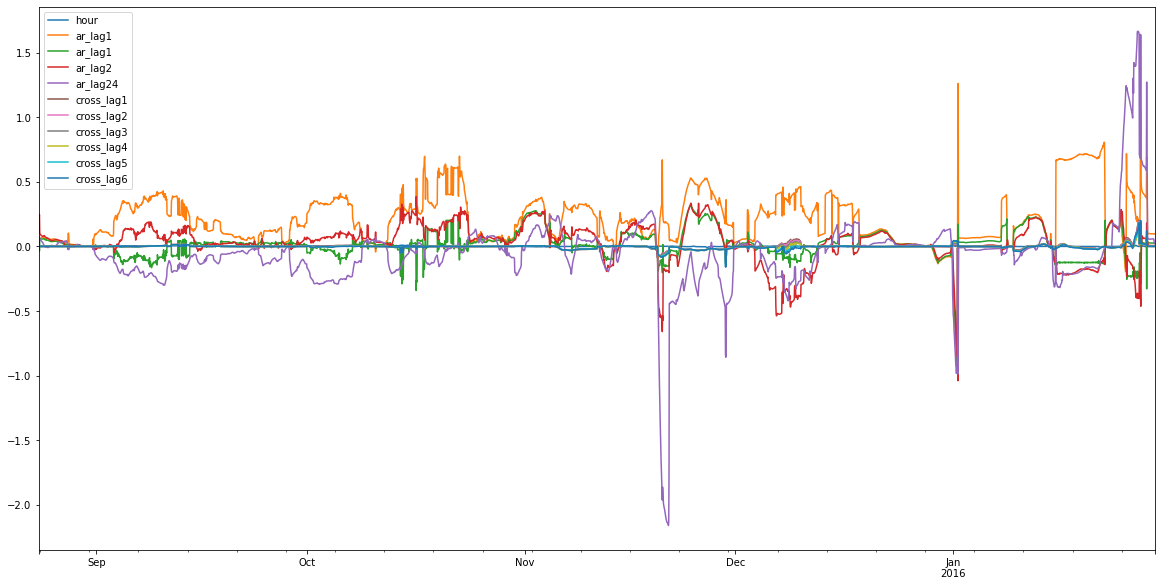

In [159]:
plt.rcParams["figure.figsize"] = (20, 10)
tmp_df = pd.DataFrame(list_coef_cross, columns=colnames_withcross, index = list_datetime_test)
tmp_df.plot()
plt.show()

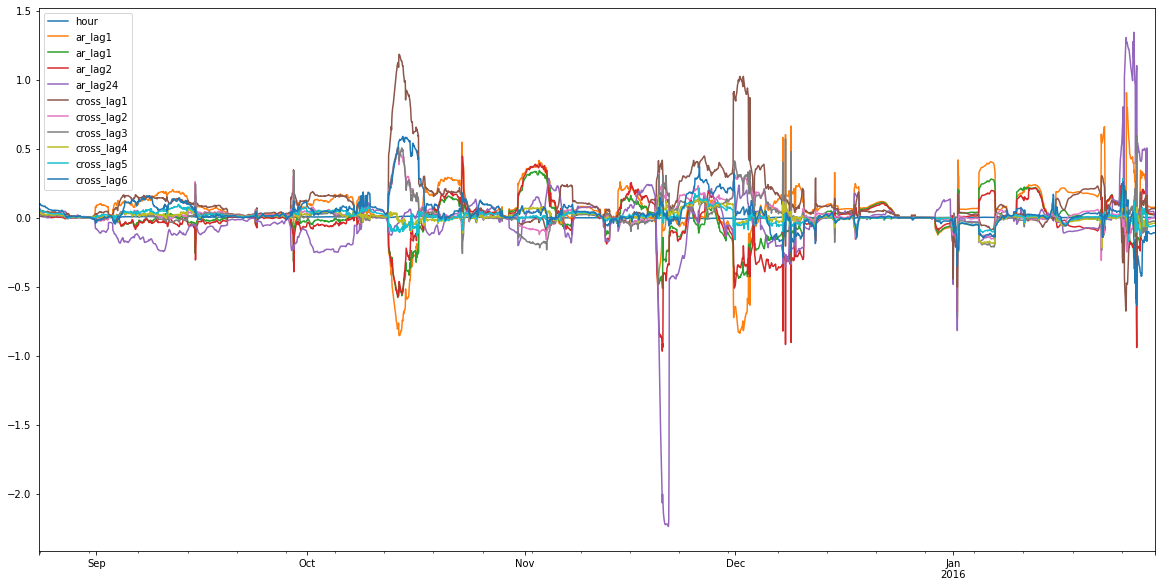

In [160]:
plt.rcParams["figure.figsize"] = (20, 10)
tmp_df = pd.DataFrame(list_coef_crossresid, columns=colnames_withcross, index = list_datetime_test)
tmp_df.plot()
plt.show()

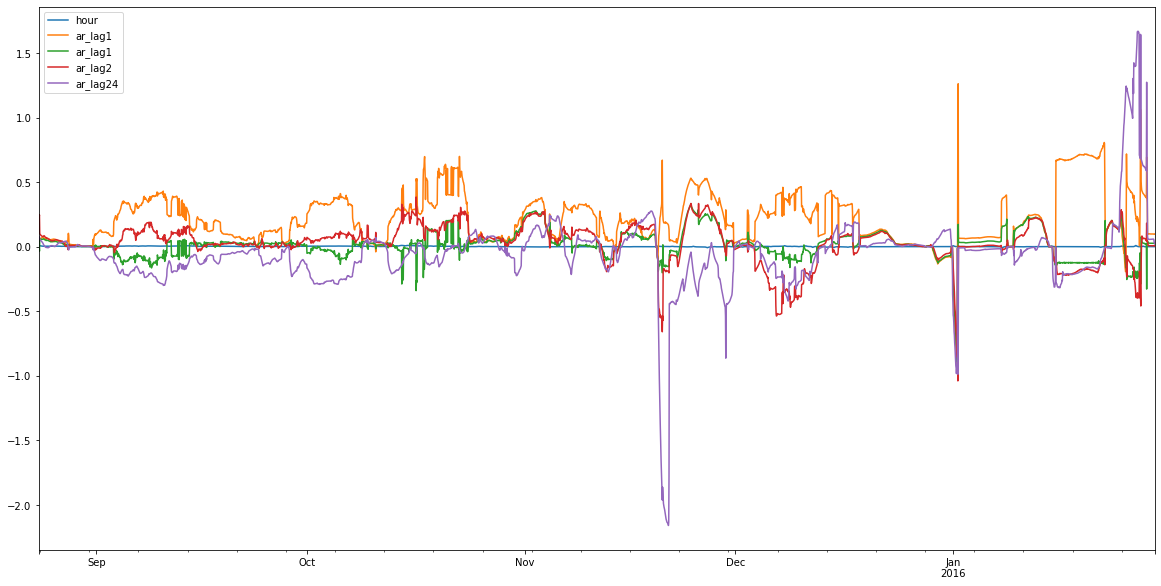

In [161]:
plt.rcParams["figure.figsize"] = (20, 10)
tmp_df = pd.DataFrame(list_coef_nocross, columns=colnames_nocross, index = list_datetime_test)
tmp_df.plot()
plt.show()

In [ ]:
# Plot coef against test time -- change weather pattern in a year
# Coef switch to 0 (look at literatures whether done yet)

## State-space

#### GHMM

In [14]:
class GHMM():
    
    def __init__(self, n_components=3, covariance_type="full", n_iter=10):
        self.n_components = n_components
        self.covariance_type = covariance_type 
        self.n_iter = n_iter
        self.tol = 0.01
        self.min_covar = 0.001
        return
    
    
    def fit_predict(self, X, is_multiple_sequence = False):
        
        matmul_log = lambda A, log_b: np.array([logsumexp(np.log(tmp_line) + log_b) for tmp_line in A])
        
        if is_multiple_sequence:
            list_X = [np.array(i) for i in X]
        else:
            list_X = [np.array(X)]
        
        marginal_X = np.concatenate(list_X)
        
        gmm = GaussianMixture(n_components = self.n_components, covariance_type = self.covariance_type)
        gmm.fit(marginal_X)
        
        n_seq = len(list_X)
        p = len(list_X[0][0])
        list_T = [len(i) for i in list_X]
        self.n_features = p
        K = self.n_components
        
        cur_transmat = np.array([[1. / K for j in range(K)] for i in range(K)])
        self.transmat_ = cur_transmat

        self.list_loglik_ = []
        for epoch in range(self.n_iter):

            # M-step
            if epoch != 0:
                
                tmp_weight_mat = []
                for cur_log_forward_prob, cur_log_backward_prob in zip(list_cur_log_forward_prob, list_cur_log_backward_prob):
                    tmp_log_weight_mat = cur_log_forward_prob + cur_log_backward_prob
                    tmp_log_weight_mat -= logsumexp(tmp_log_weight_mat[-1, :])
                    tmp_weight_mat.append(np.exp(tmp_log_weight_mat))
                tmp_weight_mat = np.concatenate(tmp_weight_mat)
            else:
                tmp_weight_mat = gmm.predict_proba(marginal_X)

            cur_list_mvn_mean_cov = []
            for ii in range(K):                
                tmp_weight = tmp_weight_mat[:, ii]
                tmp_mean = np.array([np.sum(tmp_weight * marginal_X[:, j]) / np.sum(tmp_weight) for j in range(p)])
                if self.covariance_type == "full":
                    tmp_cov_sum = np.diag([0. for i in range(p)]) 
                    for jj in range(len(marginal_X)):
                        tmp_x = marginal_X[jj, :] - tmp_mean
                        tmp_cov_sum += np.outer(tmp_x, tmp_x) * tmp_weight[jj]
                    tmp_cov = tmp_cov_sum / np.sum(tmp_weight) 
                    np.fill_diagonal(tmp_cov, [max(j, self.min_covar) for j in np.diag(tmp_cov)])
                elif self.covariance_type == "diag":
                    tmp_cov = [np.sum(tmp_weight * (marginal_X[:, j] - tmp_mean[j]) ** 2) / np.sum(tmp_weight)  for j in range(p)]
                    tmp_cov = np.array([max(j, self.min_covar) for j in tmp_cov])                 
                cur_list_mvn_mean_cov.append((tmp_mean, tmp_cov))
            self.list_mvn_mean_cov = cur_list_mvn_mean_cov
            
            # if epoch != 0:
            #     print("emission updated, current loglik =", self.find_loglik(list_X, is_multiple_sequence = True))
            
            # list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
            # for ii, (tmp_mean, tmp_cov) in enumerate(cur_list_mvn_mean_cov):
            #     for index_X, X in enumerate(list_X):
            #         if self.covariance_type == "full":
            #             list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(X, mean=tmp_mean, cov=tmp_cov)
            #         elif self.covariance_type == "diag":
            #             tmp_logprob = 0
            #             for jj in range(p):
            #                 tmp_logprob += scipy.stats.norm.logpdf(X[:, jj], loc = tmp_mean[jj], scale = np.sqrt(tmp_cov[jj]))
            #             list_cur_mat_log_b[index_X][:, ii] = tmp_logprob
            list_cur_mat_log_b = self._calc_emission_mat(list_X, is_multiple_sequence = True)
            list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
                        
            if epoch != 0:
                cur_log_initprob = [list_cur_log_forward_prob[i][0] + list_cur_log_backward_prob[i][0] for i in range(n_seq)]
            else:
                cur_log_initprob = [[np.log(i) if i != 0 else -100 for i in line] for line in gmm.predict_proba([X[0] for X in list_X])]
            
            cur_log_initprob = np.sum(cur_log_initprob, axis = 0)
            cur_log_initprob -= logsumexp(cur_log_initprob)
            self.startprob_ = np.exp(cur_log_initprob)
            self.log_startprob_ = cur_log_initprob

            # E-step      
            list_cur_log_forward_prob = [[] for i in range(n_seq)]
            for index_X, X in enumerate(list_X):
                for tt in range(len(X)):
                    if tt == 0:
                        tmp_log_prob = cur_log_initprob + list_cur_mat_log_b[index_X][0, :]
                    else:
                        tmp_log_prob = matmul_log(np.transpose(cur_transmat), list_cur_log_forward_prob[index_X][-1]) + list_cur_mat_log_b[index_X][tt, :]
                    list_cur_log_forward_prob[index_X].append(tmp_log_prob)
            list_cur_log_forward_prob = [np.array(i) for i in list_cur_log_forward_prob]
            
            list_cur_log_backward_prob = [[0 for i in range(T)] for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1, -1, -1):
                    if tt == T - 1:
                        tmp_log_prob = np.array([np.log(1.) for i in range(K)])
                    else:
                        tmp_log_prob = []
                        for ii in range(K):
                            tmp_log_prob.append(logsumexp([np.log(cur_transmat[ii, j]) + list_cur_mat_log_b[index_X][tt + 1, j] + list_cur_log_backward_prob[index_X][tt + 1][j] for j in range(K)]))
                        tmp_log_prob = np.array(tmp_log_prob)
                    list_cur_log_backward_prob[index_X][tt] = tmp_log_prob
            list_cur_log_backward_prob = [np.array(i) for i in list_cur_log_backward_prob]
            
            list_tmp_array2d_log_gamma = [i + j for (i, j) in zip(list_cur_log_forward_prob, list_cur_log_backward_prob)]
            list_tmp_array1d_log_gamma_sum = [[logsumexp(i[t, :]) for t in range(len(i))] for i in list_tmp_array2d_log_gamma]
            
            list_tmp_array3d_log_epsilon = [np.zeros(shape = (T - 1, K, K)) for T in list_T]
            for index_X, (X, T) in enumerate(zip(list_X, list_T)):
                for tt in range(T - 1):
                    for ii in range(K):
                        for jj in range(K):
                            list_tmp_array3d_log_epsilon[index_X][tt, ii, jj] = list_cur_log_forward_prob[index_X][tt, ii] + np.log(cur_transmat[ii, jj]) + \
                                    list_cur_log_backward_prob[index_X][tt + 1, jj] + list_cur_mat_log_b[index_X][tt + 1, jj] - list_tmp_array1d_log_gamma_sum[index_X][tt]            
            
            cur_transmat = np.zeros((K, K)) 
            for ii in range(K):
                tmp_list_log_prob = []
                for jj in range(K):
                    tmp_log_prob = []
                    for index_X in range(n_seq):
                        tmp_log_prob.append(logsumexp(list_tmp_array3d_log_epsilon[index_X][:, ii, jj]))
                    tmp_list_log_prob.append(logsumexp(tmp_log_prob))
                tmp_list_log_prob = np.array(tmp_list_log_prob)
                tmp_list_log_prob -= np.max(tmp_list_log_prob)
                tmp_prob = np.exp(tmp_list_log_prob)
                tmp_prob /= sum(tmp_prob)
                cur_transmat[ii, :] = tmp_prob
            
            self.transmat_ = cur_transmat
            
            #loglik = self.find_loglik(list_X, is_multiple_sequence = True)
            loglik = np.sum([logsumexp(i[-1]) for i in list_cur_log_forward_prob])
            self.list_loglik_.append(loglik)
            
            if (len(self.list_loglik_) >= 2) and (abs(self.list_loglik_[-1] - self.list_loglik_[-2]) < self.tol):
                break
            
            #print("epoch % s, loglik = % s" % (epoch, loglik))
            #print(cur_list_mvn_mean_cov)
            #print(cur_transmat)
        
        self.list_mvn_mean_cov = cur_list_mvn_mean_cov
        self.means_, self.covars_ = [], []
        for tmp_mean, tmp_cov in cur_list_mvn_mean_cov:
            self.means_.append(tmp_mean)
            self.covars_.append(tmp_cov)
        self.means_, self.covars_ = np.array(self.means_), np.array(self.covars_)
        
        self.list_last_posterior = [i[-1] + j[-1] for (i, j) in zip(list_cur_log_backward_prob, list_cur_log_forward_prob)]
        pred = []
        for ii in range(n_seq):
            tmp = self.list_last_posterior[ii]
            tmp -= np.max(tmp)
            tmp = np.exp(tmp)
            tmp /= np.sum(tmp)
            self.list_last_posterior[ii] = tmp
            pred.append(tmp @ cur_transmat @ self.means_)
        if not is_multiple_sequence:
            pred = pred[0]
        
        return pred
    
    
    def fit(self, X, is_multiple_sequence = False):
        self.fit_predict(X = X, is_multiple_sequence = is_multiple_sequence)
        return
    
    
    def _calc_emission_mat(self, X, is_multiple_sequence = False):
        
        if is_multiple_sequence:
            list_X = [np.array(i) for i in X]
        else:
            list_X = [np.array(X)]
        list_T = [len(i) for i in list_X]
        p, K = self.n_features, self.n_components
        
        list_cur_mat_log_b = [np.zeros(shape = (i, K)) for i in list_T]
        for ii, (tmp_mean, tmp_cov) in enumerate(self.list_mvn_mean_cov):
            for index_X, X in enumerate(list_X):
                if self.covariance_type == "full":
                    list_cur_mat_log_b[index_X][:, ii] = scipy.stats.multivariate_normal.logpdf(X, mean=tmp_mean, cov=tmp_cov)
                elif self.covariance_type == "diag":
                    tmp_logprob = 0
                    for jj in range(p):
                        tmp_logprob += scipy.stats.norm.logpdf(X[:, jj], loc = tmp_mean[jj], scale = np.sqrt(tmp_cov[jj]))
                    list_cur_mat_log_b[index_X][:, ii] = tmp_logprob

        return list_cur_mat_log_b
    
    
#     def find_loglik(self, X, is_multiple_sequence = False):
#         if is_multiple_sequence:
#             list_X = [np.array(i) for i in X]
#         else:
#             list_X = [np.array(X)]
#         list_T = [len(X) for X in list_X]
#         n_seq = len(list_X)
#         list_cur_list_trans_mat = [[self.transmat_ for tt in range(T)] for T in list_T]
#         list_cur_mat_log_b = self._calc_emission_mat(list_X, is_multiple_sequence = True)
#         list_list_log_emission = [[np.copy(list_cur_mat_log_b[index_X][i, :]) for i in range(T)] for index_X, T in enumerate(list_T)]
#         loglik = np.sum([find_hmm_loglik(list_log_emission = list_list_log_emission[index_X], list_transmat = list_cur_list_trans_mat[index_X], start_prob = self.startprob_) for index_X in range(n_seq)])
#         return loglik
    
    
# def _test_GHMM():
    
#     list_obs_L = []
#     for ii in range(5):
#         h_label_L, h_prob_L, obs_L = data_generator(timestamp=1000 * (ii + 1), 
#                        trans_mat=np.array([[0.9, 0.05,  0.05], [ 0.3, 0.6,  0.1], [ 0.3,  0.2, 0.5]]), 
#                        sigma2 = 0.5, random_state = 0, p = 10)
#         list_obs_L.append(obs_L)
#     ghmm = GHMM(n_components=3, covariance_type="full")
#     pred = ghmm.fit_predict(list_obs_L, is_multiple_sequence=True)
#     print(pred)
#     print(ghmm.means_)
#     print(ghmm.covars_)
#     print(ghmm.transmat_)
#     return


# _test_GHMM()


In [15]:
ghmm = GHMM(n_components=3, covariance_type="full", n_iter = 30)
ghmm.min_covar = 1e-16
ghmm.tol = 0.
ghmm.fit([np.reshape(i, (-1, 1)) for i in list_subseq], is_multiple_sequence=True)

In [16]:
ghmm.means_

array([[0.10108457],
       [0.68258465],
       [2.16098989]])

In [17]:
np.sqrt(ghmm.covars_)

array([[[0.0719295 ]],

       [[0.29091889]],

       [[1.12398549]]])

In [18]:
ghmm.transmat_

array([[9.83862098e-01, 1.61379004e-02, 1.61613331e-09],
       [1.48620417e-02, 9.66405114e-01, 1.87328444e-02],
       [1.39126328e-56, 4.68206921e-02, 9.53179308e-01]])

## End of NB

In [23]:
n = 1537
cur_max = 0
for ii in range(n):
    cur_pos = [ii]
    while True:
        tmp_max = 0
        tmp_pos = -1
        for jj in range(n):
            tmp_max_1 = min([abs(jj - k) for k in cur_pos])
            if tmp_max_1 > tmp_max:
                tmp_max = tmp_max_1
                tmp_pos = jj
        if tmp_max < 2:
            break
        else:
            cur_pos.append(tmp_pos)
            
    print(ii, len(cur_pos))
    
    if cur_max < len(cur_pos):
        cur_max = len(cur_pos)
        best_start = ii

print(best_start)


0 513
1 513
2 514
3 514
4 515
5 515
6 515
7 516
8 517
9 517
10 517
11 517
12 517
13 518
14 519
15 520
16 521
17 521
18 521
19 521
20 521
21 521
22 521
23 521
24 521
25 522
26 523
27 524
28 525
29 526
30 527
31 528
32 529
33 529
34 529
35 529
36 529
37 529
38 529
39 529
40 529
41 529
42 529
43 529
44 529
45 529
46 529
47 529
48 529
49 530
50 531
51 532
52 533
53 534
54 535
55 536
56 537
57 538
58 539
59 540
60 541
61 542
62 543
63 544
64 545
65 545
66 545
67 545
68 545
69 545
70 545
71 545
72 545
73 545
74 545
75 545
76 545
77 545
78 545
79 545
80 545
81 545
82 545
83 545
84 545
85 545
86 545
87 545
88 545
89 545
90 545
91 545
92 545
93 545
94 545
95 545
96 545
97 546
98 547
99 548
100 549
101 550
102 551
103 552
104 553
105 554
106 555
107 556
108 557
109 558
110 559
111 560
112 561
113 562
114 563
115 564
116 565
117 566
118 567
119 568
120 569
121 570
122 571
123 572
124 573
125 574
126 575
127 576
128 577
129 577
130 577
131 577
132 577
133 577
134 577
135 577
136 577
137 577
138 57